In [152]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam

import re
import string
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd

In [153]:
# import os
# os.environ['WANDB_MODE'] = 'offline'


### Load dataset

In [154]:
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False
"Running in colab" if IN_COLAB else "Running locally"

'Running in colab'

### Init wandb

In [155]:
if IN_COLAB:
  !pip install wandb -q
  !pip install python-dotenv -q
  !pip install ruamel.yaml -q

import wandb

from wandb.keras import (
   WandbMetricsLogger,
   WandbModelCheckpoint,
)
from ruamel.yaml import YAML

In [156]:
import os
from dotenv import load_dotenv; load_dotenv("wandb.env")

wandb.login(key=os.environ.get("api_key"))

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [157]:
yaml=YAML(typ='safe')
with open('trans_params.yaml', 'r') as file:
    config_file = yaml.load(file)

wandb.init(
    # set the wandb project where this run will be logged
    project="CRNN_translate",

    # name="test_log_text",
    # notes="Removed gradient clipping",
    config=config_file,
    save_code=True,
)
# wandb.run.log_code(include_fn=lambda path: path.endswith("translate_train.ipynb"))
wandb.run.log_code(include_fn=lambda path: path.endswith(".ipynb") or path.endswith(".py"))
config = wandb.config

In [158]:
UNITS = config["hidden_dims"]
input_dim = config["input_size"]

### Dataset loading

In [159]:
if IN_COLAB:
    # download dataset

    import pathlib

    path_to_zip = tf.keras.utils.get_file(
        'spa-eng.zip', origin='http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip',
        extract=True)

    path_to_file = pathlib.Path(path_to_zip).parent/'spa-eng/spa.txt'

    def load_data(path):
        text = path.read_text(encoding='utf-8')

        lines = text.splitlines()
        pairs = [line.split('\t') for line in lines]

        context = np.array([context for target, context in pairs])
        target = np.array([target for target, context in pairs])

        return target, context

    target_raw, context_raw = load_data(path_to_file)

    print(context_raw[-1])
    print(target_raw[-1])

else:
    df = pd.read_csv("data/spa-eng.zip", delimiter="\t", names=["translate", "source", "attr"])
    context_raw = np.array(df["source"])
    target_raw = np.array(df["translate"])
    print(context_raw[-1])
    print(target_raw[-1])

BUFFER_SIZE = len(context_raw)
BATCH_SIZE = 64

is_train = np.random.uniform(size=(len(target_raw),)) < 0.8 # todo. Check reproducibility and across methods (colab/not colab)


train_raw = (
    tf.data.Dataset
    .from_tensor_slices((context_raw[is_train], target_raw[is_train]))
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE))
val_raw = (
    tf.data.Dataset
    .from_tensor_slices((context_raw[~is_train], target_raw[~is_train]))
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE))



Si quieres sonar como un hablante nativo, debes estar dispuesto a practicar diciendo la misma frase una y otra vez de la misma manera en que un músico de banjo practica el mismo fraseo una y otra vez hasta que lo puedan tocar correctamente y en el tiempo esperado.
If you want to sound like a native speaker, you must be willing to practice saying the same sentence over and over in the same way that banjo players practice the same phrase over and over until they can play it correctly and at the desired tempo.


#### My dataset processing

In [160]:
def custom_standardization(text):

  text = tf.strings.lower(text)
  text = tf.strings.regex_replace(text,
                                  '[%s]' % re.escape(string.punctuation + "¿¡"), '')
  text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
  return text
vocab_size = 5000
# sequence_length = 250



context_text_processor = tf.keras.layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=vocab_size,
    ragged=True)

context_text_processor.adapt(train_raw.map(lambda context, target: context))

# Here are the first 10 words from the vocabulary:
context_text_processor.get_vocabulary()[:10]

['', '[UNK]', '[START]', '[END]', 'de', 'que', 'a', 'no', 'tom', 'la']

In [161]:
target_text_processor = tf.keras.layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=vocab_size,
    ragged=True)

target_text_processor.adapt(train_raw.map(lambda context, target: target))
target_text_processor.get_vocabulary()[:10]

['', '[UNK]', '[START]', '[END]', 'the', 'i', 'to', 'you', 'tom', 'a']

#### End of text processings

In [162]:
def process_text(context, target):
  context = context_text_processor(context).to_tensor()
  target = target_text_processor(target)
  targ_in = target[:,:-1].to_tensor()
  targ_out = target[:,1:].to_tensor()
  return (context, targ_in), targ_out


train_ds = train_raw.map(process_text, tf.data.AUTOTUNE)
val_ds = val_raw.map(process_text, tf.data.AUTOTUNE)

In [163]:
def masked_loss(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')
    loss = loss_fn(y_true, y_pred)

    # Mask off the losses on padding.
    mask = tf.cast(y_true != 0, loss.dtype)
    loss *= mask

    # Return the total.
    return tf.reduce_sum(loss)/tf.reduce_sum(mask)

In [164]:
def masked_acc(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    y_pred = tf.argmax(y_pred, axis=-1)
    y_pred = tf.cast(y_pred, y_true.dtype)

    match = tf.cast(y_true == y_pred, tf.float32)
    mask = tf.cast(y_true != 0, tf.float32)

    return tf.reduce_sum(match)/tf.reduce_sum(mask)

### define model

In [165]:
%load_ext autoreload

%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [166]:
if config["model"] == "attention_gru":
    from attention_gru_translate_model  import Translator
    # wandb.run.log_code(include_fn=lambda path: path.endswith("attention_gru_translate_model.py"))

    model_kwargs = {"attention": True}

elif config["model"] == "gru":

    from gru_translate_model  import Translator
    # wandb.run.log_code(include_fn=lambda path: path.endswith("attention_gru_translate_model.py"))

    model_kwargs = {}

elif config["model"] == "crnn":
    from context_rnn_translate_model import Translator
    # wandb.run.log_code(include_fn=lambda path: path.endswith("attention_gru_translate_model.py"))

    model_kwargs = {}
# elif config["model"] == "attention_crnn":
#     from context_rnn_translate_model import Translator
#     # wandb.run.log_code(include_fn=lambda path: path.endswith("attention_gru_translate_model.py"))

#     model_kwargs = {"attention": True}
else:
    raise NotImplementedError("Model " + config["model"] + " is not implemented")

In [167]:
model = Translator(UNITS, context_text_processor, target_text_processor, input_dim, **model_kwargs)

In [168]:
model.compile(optimizer=Adam(learning_rate=config["lr"]),
              loss=masked_loss,
              metrics=[masked_acc, masked_loss])

In [169]:
history = model.fit(
    train_ds.repeat(),
    epochs=config["epochs"],
    steps_per_epoch = 100,
    validation_data=val_ds,
    validation_steps = 20,  # todo -- убедиться, что это не делает ничего странного.
    callbacks=[
        # tf.keras.callbacks.EarlyStopping(patience=3),
        WandbMetricsLogger()])

Epoch 1/120
100/100 [==============================] - 40s 290ms/step - loss: 6.1113 - masked_acc: 0.1677 - masked_loss: 6.1113 - val_loss: 5.5124 - val_masked_acc: 0.1655 - val_masked_loss: 5.5124
Epoch 2/120
100/100 [==============================] - 6s 61ms/step - loss: 5.3651 - masked_acc: 0.1885 - masked_loss: 5.3651 - val_loss: 5.1415 - val_masked_acc: 0.2066 - val_masked_loss: 5.1415
Epoch 3/120
100/100 [==============================] - 6s 63ms/step - loss: 5.0292 - masked_acc: 0.2163 - masked_loss: 5.0292 - val_loss: 4.8424 - val_masked_acc: 0.2333 - val_masked_loss: 4.8424
Epoch 4/120
100/100 [==============================] - 4s 42ms/step - loss: 4.7701 - masked_acc: 0.2393 - masked_loss: 4.7701 - val_loss: 4.6320 - val_masked_acc: 0.2538 - val_masked_loss: 4.6320
Epoch 5/120
100/100 [==============================] - 4s 38ms/step - loss: 4.5494 - masked_acc: 0.2602 - masked_loss: 4.5494 - val_loss: 4.4014 - val_masked_acc: 0.2769 - val_masked_loss: 4.4014
Epoch 6/120
100/10

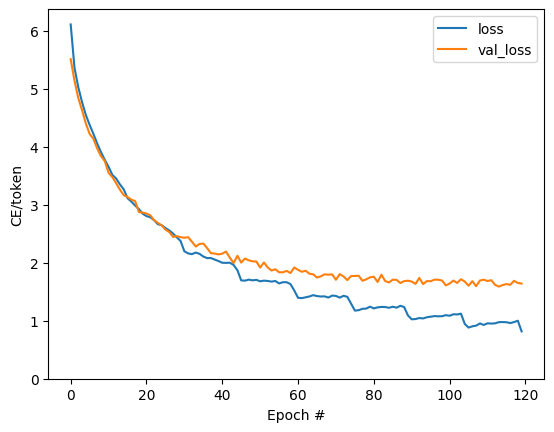

In [170]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

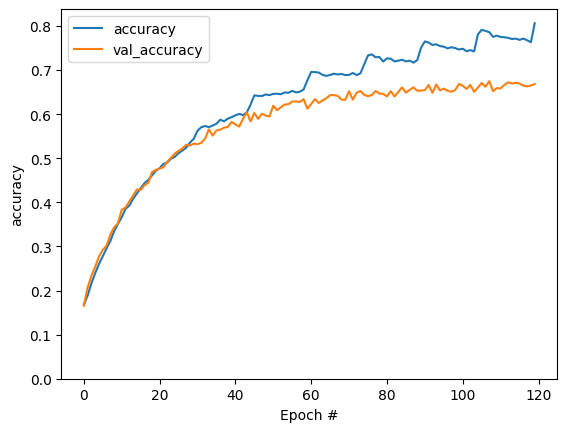

In [171]:
plt.plot(history.history['masked_acc'], label='accuracy')
plt.plot(history.history['val_masked_acc'], label='val_accuracy')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('accuracy')
plt.legend()

In [172]:
# result = model.translate(['¿Todavía está en casa?']) # Are you still home
# result[0].numpy().decode()

In [173]:
# for i in range(len(history.history['masked_acc'])):
#   wandb.log({
#   # print({
#       "train_accuracy": history.history['masked_acc'][i],
#       "test_accuracy": history.history['val_masked_acc'][i],
#       "train_loss": history.history['masked_loss'][i],
#       "test_loss": history.history['val_masked_loss'][i],
#   })

### Examples of translation

In [174]:
text_table = wandb.Table(columns=["source", "translate", "target", "temperature"])
n_samples = 10

for context_strings, target_strings in train_raw.take(1):
    for temp in np.arange(0.1, 0.7, 0.1):
        translate_strings = model.translate(context_strings, temperature=temp)

        decoded_strings = [x.numpy() for x in
                           [context_strings, translate_strings, target_strings]]
        print("Temperature is", np.round(temp, 2))
        for i in range(min(len(context_strings), n_samples)):
            for t in decoded_strings:
                print(t[i].decode())
            print()
            text_table.add_data(*[t[i] for t in decoded_strings], temp)

wandb.log({"training_samples" : text_table})

Temperature is 0.1
Ella ha conseguido sus metas.
[UNK] left 
She has achieved her goals.

La policía arrestó a Tom.
[UNK] left 
The police have arrested Tom.

Me gustaría hablar dos palabras con usted.
[UNK] left 
I'd like to have a word with you.

¿Podría darme cambio de un billete de cien dólares?
[UNK] left 
Could you give me change out of a hundred-dollar bill?

Nuestro profesor es un verdadero idiota.
[UNK] left 
Our teacher is a real idiot.

Ayer robaron el bate, junto con las pelotas.
[UNK] left 
The bat was stolen yesterday, along with the balls.

Tom tiene un auto deportivo amarillo.
[UNK] left 
Tom owns a yellow sports car.

Tom es el tipo que Mary quería.
[UNK] left 
Tom is the guy that Mary wanted.

Él es el capitán de un equipo.
[UNK] left 
He's the captain of a team.

Con frecuencia, la metadona se prescribe como analgésico.
[UNK] left 
Methadone is commonly prescribed as a pain killer.

Temperature is 0.2
Ella ha conseguido sus metas.
[UNK] left   
She has achieved her g

In [175]:
wandb.finish()

epoch/epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▆▆▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▂▂▂▂▁▁▁▁▁▁▁▁▁▁
epoch/masked_acc,▁▂▂▃▃▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇█▇▇▇▇█████
epoch/masked_loss,█▆▆▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▂▂▂▂▁▁▁▁▁▁▁▁▁▁
epoch/val_loss,█▆▆▅▄▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_masked_acc,▁▂▃▄▄▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇██████████████████
epoch/val_masked_loss,█▆▆▅▄▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/epoch,119
epoch/learning_rate,0.001
epoch/loss,0.8169
